In [1]:
import pandas as pd
import numpy as np
import calculate_cleavage_rate as clv
%matplotlib inline 
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')
current_colors = sns.color_palette()
reload(clv)
import sys
import Nucleaseq_data_processing as processing
reload(processing)
import read_model_ID as model
import coarse_grain as cg
reload(cg)
reload(model)
guide = 20

sys.path.append('Toy_model')
import read_model_ID_toy as model_toy
import calculate_cleavage_rate_toy as clv_toy
reload(clv_toy)

<module 'calculate_cleavage_rate_toy' from 'Toy_model\calculate_cleavage_rate_toy.pyc'>

## Full model

PAM: 2.73766502381
From solution: -3.06621098336
Internal: 2.80705381635
Cleavage: 0.378917952653


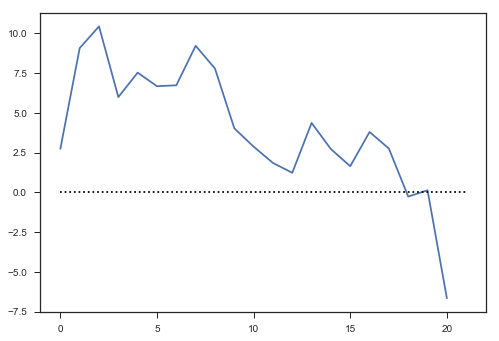

In [2]:
#-----Load in the full model----------
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

#filename = 'fit_8_8_2019_sim_3.txt'
#path = '../fits_Stijn/8_8_2019/'
#data = pd.read_table(path+filename,index_col=False)
#chi = data.loc[:,'Potential']
#final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
#final_par_np = np.array(final_par.values)


model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)

plt.plot(range(0,21), -np.cumsum(np.append(-energies[0],energies[1:21])))
plt.plot([0,21],[0,0],'k:')

print 'PAM: ' + str(energies[0])
print 'From solution: ' + str(parameters_on[-2])
print 'Internal: ' + str(parameters_on[-1])
print 'Cleavage: ' + str(parameters_clv[-1])

## Coarse Graining

C:\Users\beslamimossall\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


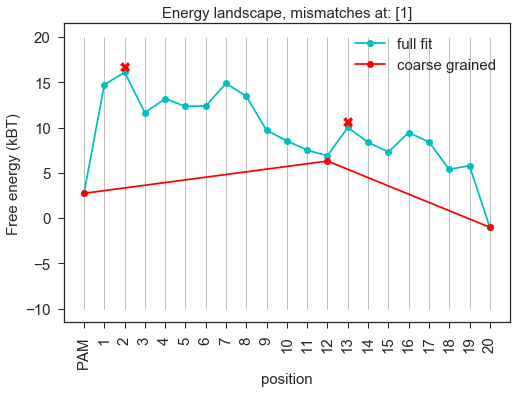

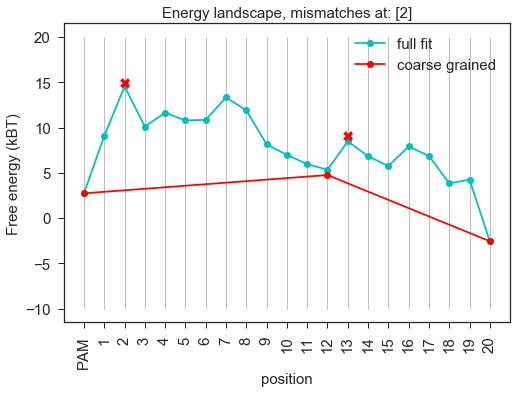

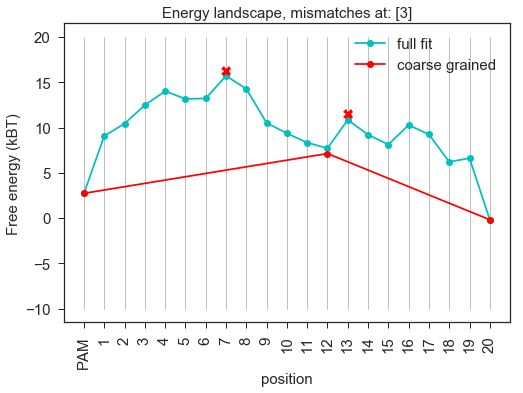

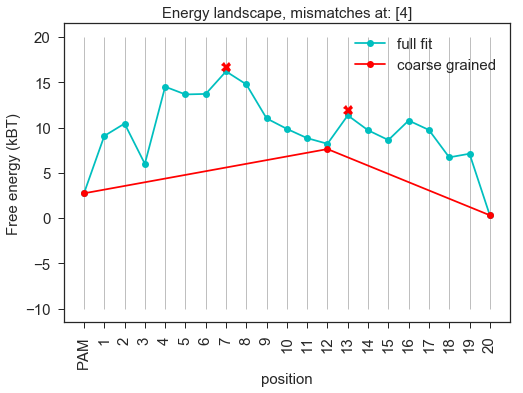

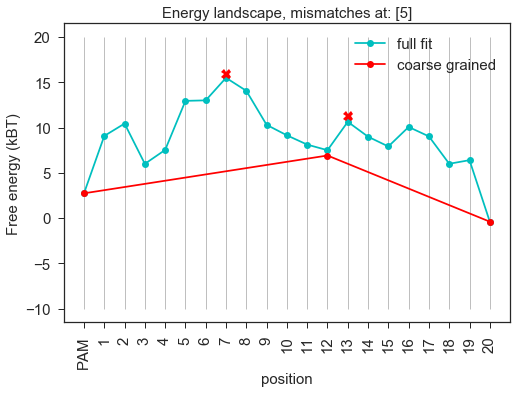

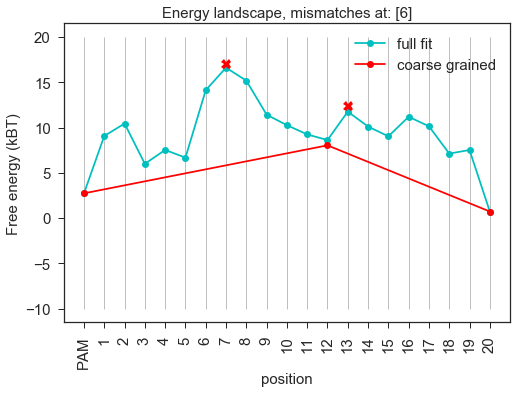

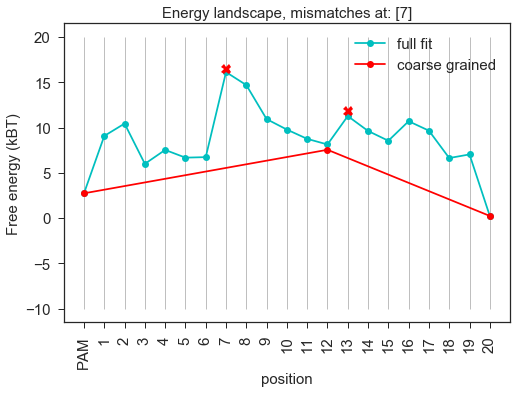

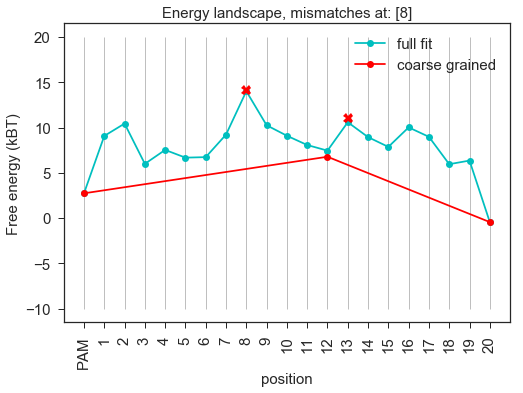

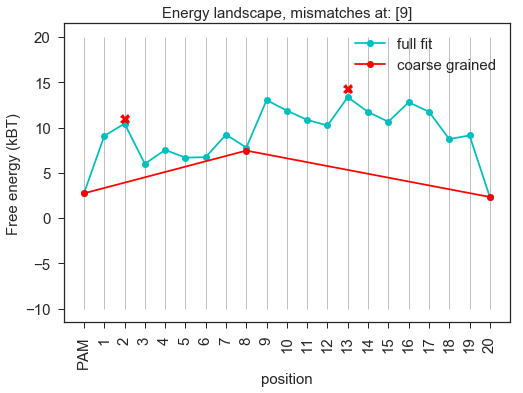

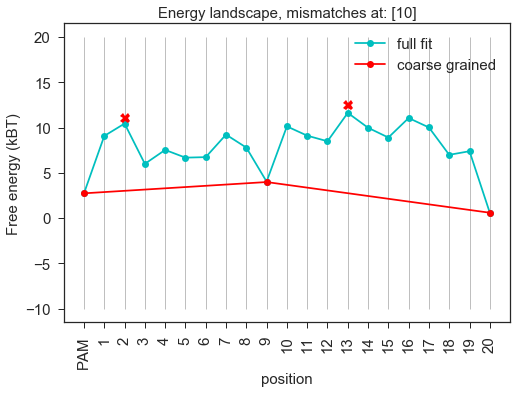

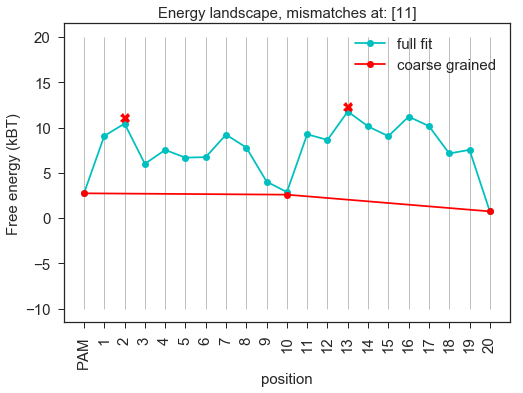

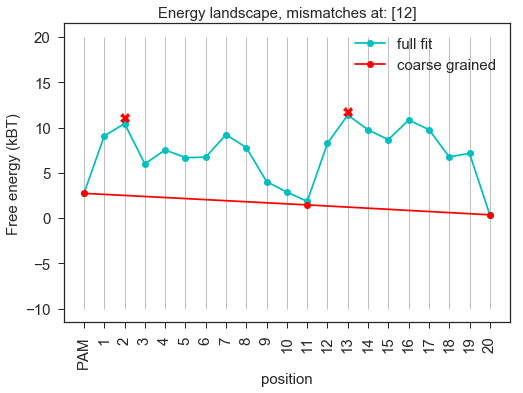

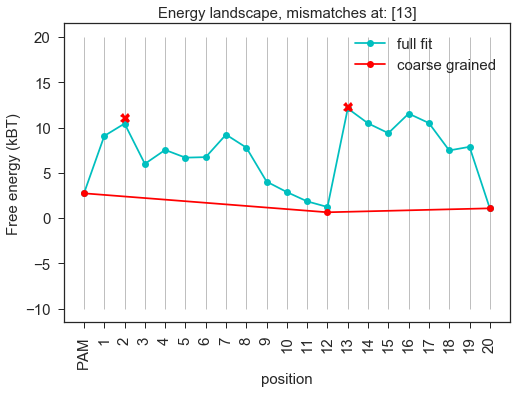

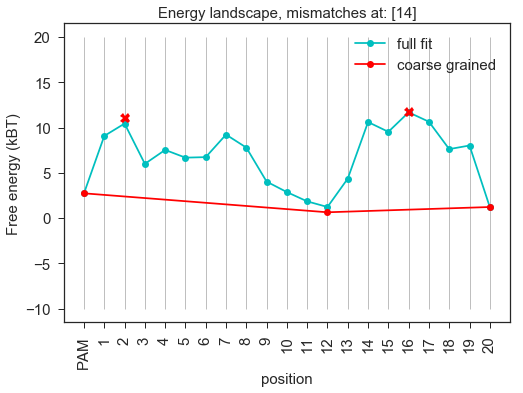

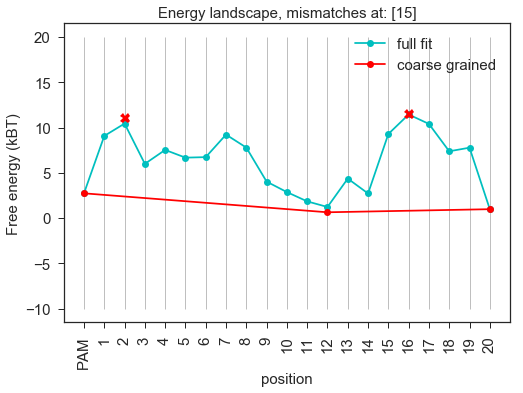

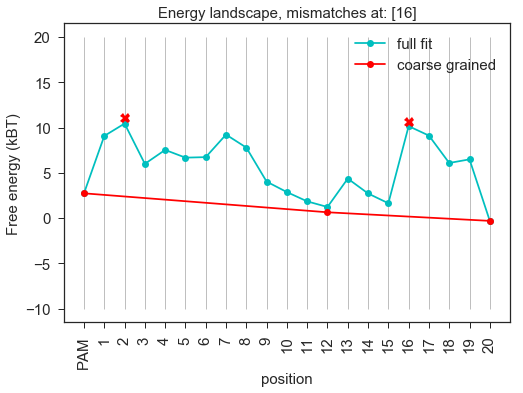

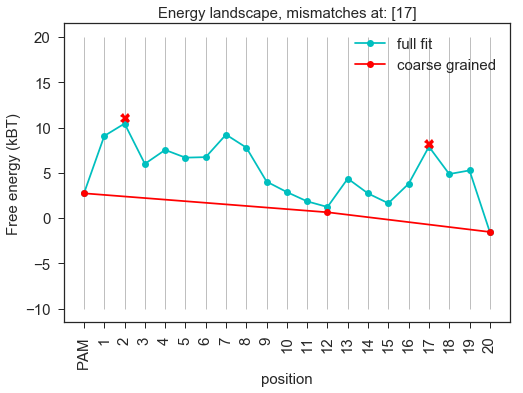

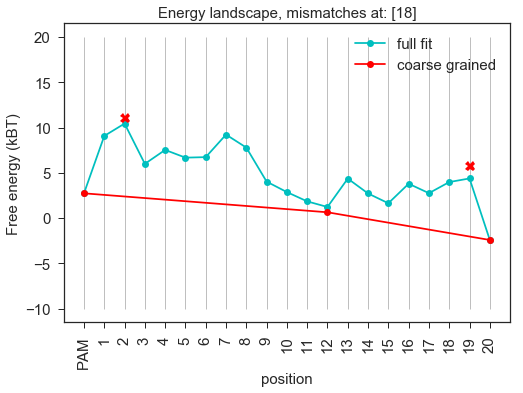

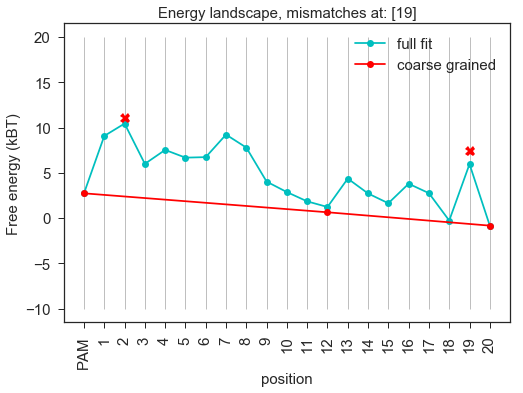

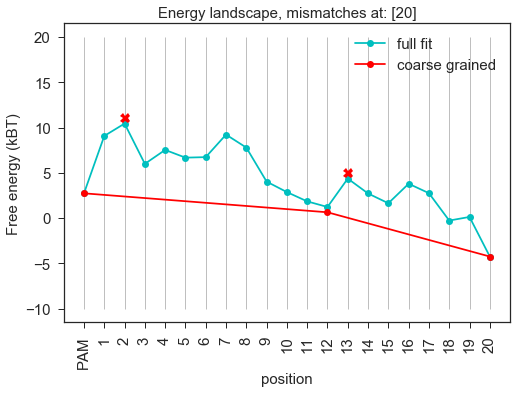

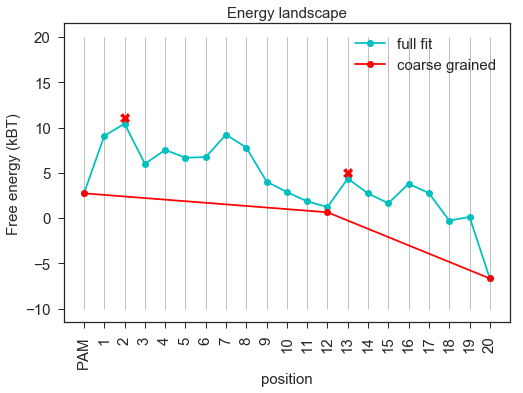

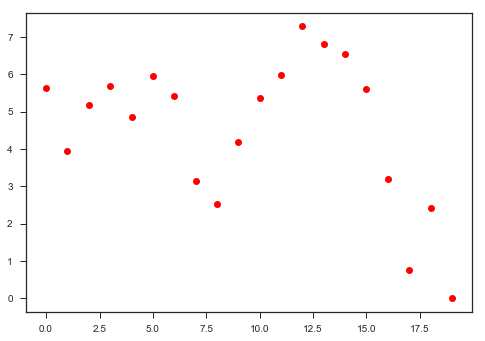

In [3]:
# plot all smm coarse grained landscapes, and also plot 'coarse grained mismatch penalties' (not in my thesis)
eicg = []
rangeI = [7,13] # range in which we allow state I to fall
for i in range(1,22):
    ## Mismatch
    mismatch = [i]
    if i == 21:
        mismatch = []
    
    energies20 = energies.copy()
    for i in mismatch:
        energies20[i] -= energies20[i+20]
    
    rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,rangeI)
    energies_cg[0] = -energies[0]
    barrier1 = -np.log(rates_cg[0]/rates[1])
    barrier2 = -np.log(rates_cg[1]/rates[1])
    landscape4 = -np.cumsum(energies_cg)
    landscape20 = -np.cumsum(np.append(-energies20[0],energies20[1:21]))

    plt.figure()
    plot5, = plt.plot(range(0,21),landscape20,'c-o',label='full fit')
    plot1, = plt.plot([0,Istate,20],landscape4,'r-o',label='coarse grained')
    plt.plot([np.argmax(landscape20[0:Istate]),np.argmax(landscape20[Istate:])+Istate],[barrier1+landscape4[0],barrier2+landscape4[1]],'rX',markersize=10)
    plt.legend(handles=[plot5,plot1],fontsize=15)
    plt.xlabel('position',fontsize=15)
    plt.ylabel('Free energy (kBT)',fontsize=15)
    plt.title('Energy landscape',fontsize=15)
    if len(mismatch) > 0:
        plt.title('Energy landscape, mismatches at: ' + str(mismatch),fontsize=15)
    plt.vlines(range(0,21),-10,20,color='grey',linewidth=0.5);
    plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');
    plt.yticks(fontsize=15);
    
    if i < 9:
        eicg.append(barrier1)
    elif i==21:
        eicg.append(barrier1)
        eicg.append(barrier2)
    else:
        eicg.append(barrier2)

for i in range(0,8):
    eicg[i] = eicg[i] - eicg[-2]
for i in range(8,20):
    eicg[i] = eicg[i] - eicg[-1]
    
plt.figure()
plt.plot(eicg[:-2],'ro')


## Coarse graining all fits, and comparing rates

37
2


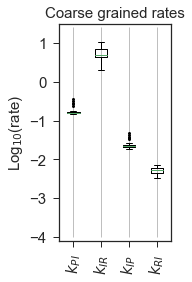

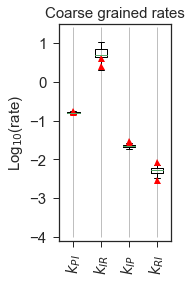

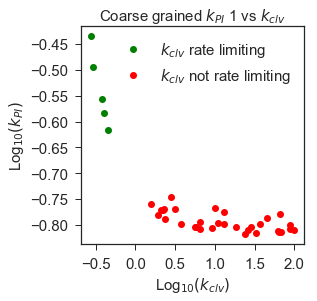

In [4]:
#-----------make box plots------------
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
rates_list = []
cleave_list = []

mismatch = [] #enter mismatch configuration here
for i in range(1,51):
    filename = 'fit_18_7_2019_sim_' + str(i) + '.txt'
    path = '../fits_Stijn/18_7_2019/'
    data = pd.read_table(path+filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    
    if np.min(chi)<290.:

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
        energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
        
        rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,rangeI)

        rates_list.append(np.log10(np.array(rates_cg)))
        cleave_list.append(np.log10(rates_clv[-1]))
print len(rates_list)

rates_list2 = []
cleave_list2 = []
for i in range(1,6):
    filename = 'fit_8_8_2019_sim_' + str(i) + '.txt'
    path = '../fits_Stijn/8_8_2019/'
    data = pd.read_table(path+filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    
    if np.min(chi)<400.:

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
        energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
        
        rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,rangeI)

        rates_list2.append(np.log10(np.array(rates_cg)))
        cleave_list2.append(np.log10(rates_clv[-1]))
print len(rates_list2)

rates_listT = np.transpose(np.array(rates_list))
rates_list = np.array(rates_list)
ro = dict(markerfacecolor='k', marker='o',markeredgecolor='k',markersize=3.)


plt.figure(figsize = [2,4])
plt.boxplot(rates_list,flierprops=ro)
plt.title('Coarse grained rates',fontsize=15)
if len(mismatch) > 0:
    plt.title('Coarse grained rates, \nmismatches at: ' + str(mismatch),fontsize=15)
plt.vlines(range(1,5),-4.,1.4,color='grey',linewidth=0.5);
plt.xticks(range(1,5),['$k_{PI}$','$k_{IR}$','$k_{IP}$','$k_{RI}$'],fontsize=15,rotation='vertical');
plt.ylabel('Log$_{10}$(rate)',fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.5,4.5,-4.1,1.5])

plt.figure(figsize = [2,4])
plt.boxplot(rates_list,showfliers=False)
plt.title('Coarse grained rates',fontsize=15)
for i in range(len(rates_list2)):
    plot2, = plt.plot(range(1,5),rates_list2[i],'r^',markersize=7.,linewidth=0,label='unconstrained $k_f$')
if len(mismatch) > 0:
    plt.title('Coarse grained rates, \nmismatches at: ' + str(mismatch),fontsize=15)
plt.vlines(range(1,5),-4.,1.4,color='grey',linewidth=0.5);
plt.xticks(range(1,5),['$k_{PI}$','$k_{IR}$','$k_{IP}$','$k_{RI}$'],fontsize=15,rotation='vertical');
plt.ylabel('Log$_{10}$(rate)',fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.5,4.5,-4.1,1.5])

    
plt.figure(figsize=[4,4])
for i in range(len(rates_list)):
    if cleave_list[i]<0.:
        plot1, = plt.plot(cleave_list[i],rates_list[i][0],'go',linewidth=0,label='$k_{clv}$ rate limiting')
    if cleave_list[i]>0.:
        plot2, = plt.plot(cleave_list[i],rates_list[i][0],'ro',linewidth=0,label='$k_{clv}$ not rate limiting')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Coarse grained $k_{PI}$ 1 vs $k_{clv}$',fontsize=15)
plt.xlabel('Log$_{10}(k_{clv})$',fontsize=15)
plt.ylabel('Log$_{10}(k_{PI})$',fontsize=15)
plt.legend(handles=[plot1,plot2],fontsize=15)

## Predicting using coarse grained rates

## Load Data

In [7]:
filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE_Stijn/'

xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,True)
_, ydatafull, yerrfull = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,False)

filename_aba = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv'
path_to_data_aba = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data_Stijn/'

_, ydata_aba, yerr_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,False)
_, ydatawa_aba, yerrwa_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,True)

kclv = []
kon = []
erron = []
aba = []
i = 1
while i < 20+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclv.append(ydata[a][0][0])
            kon.append((ydata[a][1][0]))
            aba.append((ydatawa_aba[a][1][0]))
            erron.append((yerr[a][1][0]))
            i = i + 1
    
kclv.append(ydata[0][0][0])
kclv = np.array(kclv)
kon.append((ydata[0][1][0]))
kon = np.array(kon)
aba.append((ydatawa_aba[0][1][0]))
aba = np.array(aba)
erron.append(yerr[0][1][0])
erron = np.array(erron)


k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
aba_double = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydata[a][0][0])
        aba_double[j-1,i-1] = ydatawa_aba[a][1][0]
        if len(ydata[a][1])>0:
            on_double[j-1,i-1] = (ydata[a][1][0])
        else:
            on_double[j-1,i-1] = np.nan
        
k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1, 21))
on_double_df = pd.DataFrame(on_double, index=range(1, 21), columns=range(1, 21))
aba_double_df = pd.DataFrame(aba_double, index=range(1, 21), columns=range(1, 21))

<function matplotlib.pyplot.tight_layout>

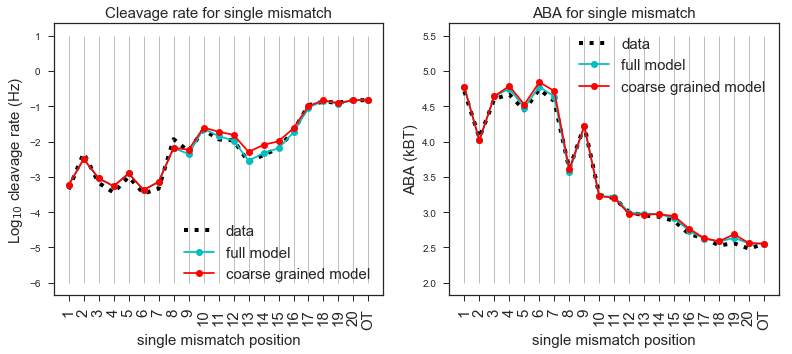

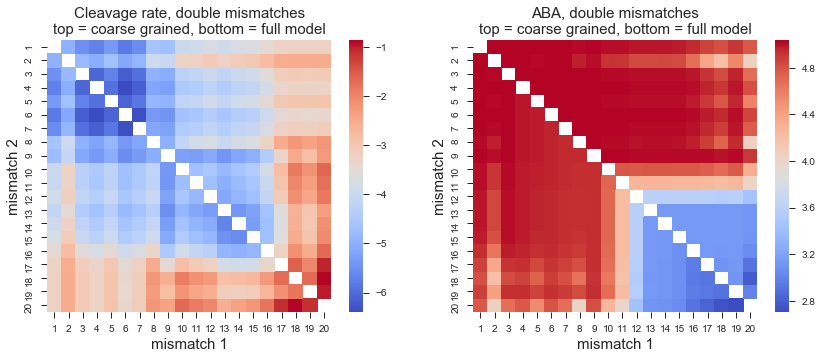

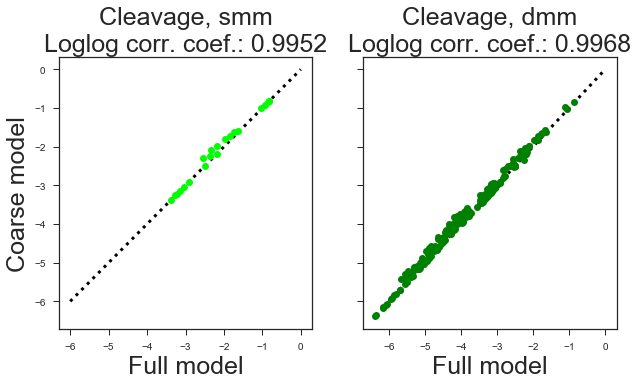

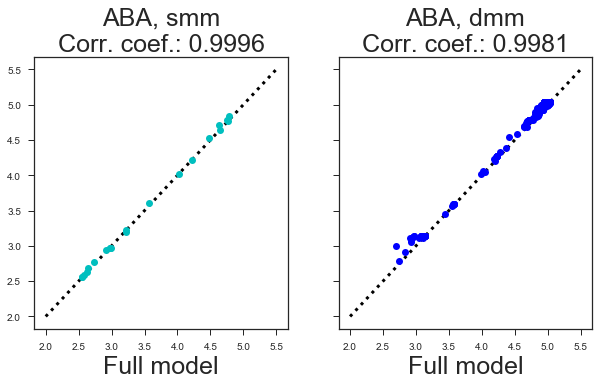

In [8]:
#First load the data below
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)

conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair

kclv_full = []
kclv_coarse = []
aba_full = []
aba_coarse = []
for i in range(1,22):
    energies20 = energies.copy()

    ## Mismatch
    mismatch = [i]
    if i == 21:
        mismatch = []
    
    rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,rangeI)
    
    kclv_coarse.append(np.log10(cg.calc_clv_rate_4state(rates_cg,1000,rates_clv[-1],energies_cg[0])))
    kclv_full.append(np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,mismatch)))
    aba_coarse.append(cg.calc_aba_4state(rates_cg,rates[0],-energies[0],conc,ref))
    aba_full.append(clv.calc_ABA(parameters_on,conc,ref,mismatch,model_ID_on))
    
f,ax = plt.subplots(1,2,sharey=False,figsize=[13,5])
ax[0].plot(range(1,22),kclv,color='k',linestyle=':',linewidth=4.)
ax[0].plot(range(1,22),kclv_full,color='c',marker='o')
ax[0].plot(range(1,22),kclv_coarse,color='r',marker='o')

ax[0].set_xticks(range(1,22));
ax[0].set_xticklabels(range(1,21)+['OT'],fontsize=15,rotation='vertical')
ax[0].legend(['data','full model','coarse grained model'],fontsize=15,loc = 'lower right')
ax[0].set_xlabel('single mismatch position', fontsize=15)
ax[0].set_ylabel('Log$_{10}$ cleavage rate (Hz)', fontsize=15)
ax[0].set_title('Cleavage rate for single mismatch', fontsize=15)
ax[0].vlines(range(1,22),-6,1,color='grey',linewidth=0.5);

ax[1].plot(range(1,22),aba,color='k',linestyle=':',linewidth=4.)
ax[1].plot(range(1,22),aba_full,color='c',marker='o')
ax[1].plot(range(1,22),aba_coarse,color='r',marker='o')

ax[1].vlines(range(1,22),2.,5.5,color='grey',linewidth=0.5)
ax[1].legend(['data','full model','coarse grained model'],fontsize=15)
ax[1].set_xlabel('single mismatch position', fontsize=15)
ax[1].set_ylabel('ABA (kBT)', fontsize=15)
ax[1].set_title('ABA for single mismatch', fontsize=15)
ax[1].set_xticks(range(1,22));
ax[1].set_xticklabels(range(1,21)+['OT'],fontsize=15,rotation='vertical')

doubleclvfull = []
doubleclvcoarse = []
doubleclv = np.zeros([20,20])

doubleabafull = []
doubleabacoarse = []
doubleaba = np.zeros([20,20])
plt.figure()
for j in range(1,20):
    for a in range(j+1,21):
        energies20 = energies.copy()

        ## Mismatch
        mismatch = [j,a]
        
        rates_cg,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,rangeI)
        
        predtemp = np.log10(cg.calc_clv_rate_4state(rates_cg,1000,rates_clv[-1],energies_cg[0]))
        doubleclv[j-1][a-1] = predtemp
        doubleclvcoarse.append(predtemp)
        clvtemp = np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,[j,a]))
        doubleclv[a-1][j-1] = clvtemp
        doubleclvfull.append(clvtemp)
        
        predtemp = cg.calc_aba_4state(rates_cg,rates[0],-energies[0],conc,ref)
        doubleaba[j-1][a-1] = predtemp
        doubleabacoarse.append(predtemp)
        abatemp = clv.calc_ABA(parameters_on,conc,ref,mismatch,model_ID_on)
        doubleaba[a-1][j-1] = abatemp
        doubleabafull.append(abatemp)
        
doubleclv_df = pd.DataFrame(doubleclv, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    doubleclv_df[i].loc[i]=np.nan
doubleaba_df = pd.DataFrame(doubleaba, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    doubleaba_df[i].loc[i]=np.nan
    
f,ax = plt.subplots(1,2,sharey=False,figsize=[14,5])
sns.heatmap(doubleclv_df, cmap='coolwarm', cbar=True,ax=ax[0])
ax[0].set_xlabel('mismatch 1', fontsize=15)
ax[0].set_ylabel('mismatch 2', fontsize=15)
ax[0].set_title('Cleavage rate, double mismatches\ntop = coarse grained, bottom = full model',fontsize=15)
sns.heatmap(doubleaba_df, cmap='coolwarm', cbar=True,ax=ax[1])
ax[1].set_xlabel('mismatch 1', fontsize=15)
ax[1].set_ylabel('mismatch 2', fontsize=15)
ax[1].set_title('ABA, double mismatches\ntop = coarse grained, bottom = full model',fontsize=15)

f,ax = plt.subplots(1,2,sharey=True,figsize=[10,5])
ax[0].plot([-6.,0.],[-6.,0.],'k:',linewidth=3.)
ax[1].plot([-6.,0.],[-6.,0.],'k:',linewidth=3.)
ax[0].plot(kclv_full,kclv_coarse,color='lime',marker='o',linewidth=0.)
ax[1].plot(doubleclvfull,doubleclvcoarse,color='g',marker='o',linewidth=0.)
ax[0].set_title('Cleavage, smm\nLoglog corr. coef.: ' + str(np.round(np.corrcoef([kclv_full,kclv_coarse])[0][1],4)), fontsize=25)
ax[1].set_title('Cleavage, dmm\nLoglog corr. coef.: '+ str(np.round(np.corrcoef([doubleclvfull,doubleclvcoarse])[0][1],4)), fontsize=25)
ax[0].set_xlabel('Full model',fontsize=25)
ax[1].set_xlabel('Full model',fontsize=25)
ax[0].set_ylabel('Coarse model',fontsize=25)

f,ax = plt.subplots(1,2,sharey=True,figsize=[10,5])
ax[0].plot([2.,5.5],[2.,5.5],'k:',linewidth=3.)
ax[1].plot([2.,5.5],[2.,5.5],'k:',linewidth=3.)
ax[0].plot(aba_full,aba_coarse,color='c',marker='o',linewidth=0.)
ax[1].plot(doubleabafull,doubleabacoarse,color='b',marker='o',linewidth=0.)
ax[0].set_title('ABA, smm\nCorr. coef.: ' + str(np.round(np.corrcoef([aba_full,aba_coarse])[0][1],4)), fontsize=25)
ax[1].set_title('ABA, dmm\nCorr. coef.: '+ str(np.round(np.corrcoef([doubleabafull,doubleabacoarse])[0][1],4)), fontsize=25)
ax[0].set_xlabel('Full model',fontsize=25)
ax[1].set_xlabel('Full model',fontsize=25)
#ax[0].set_ylabel('Coarse model',fontsize=20)
        
plt.tight_layout

## Below I tested to different ways of handling the last state R (not really in my thesis)

## Flexible R

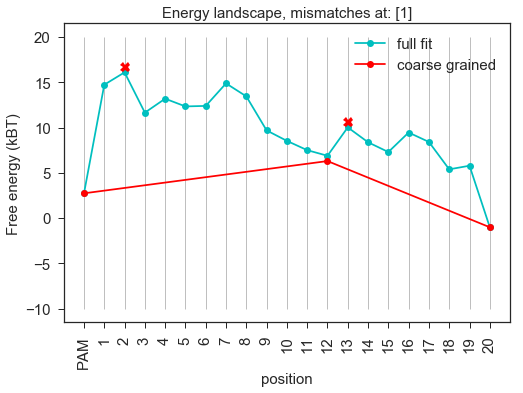

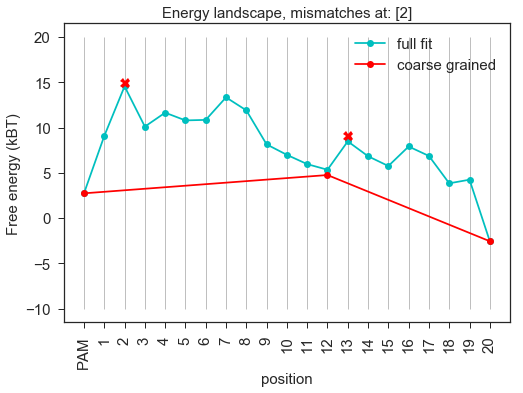

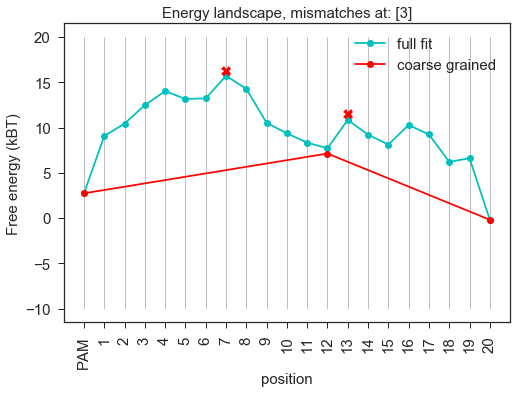

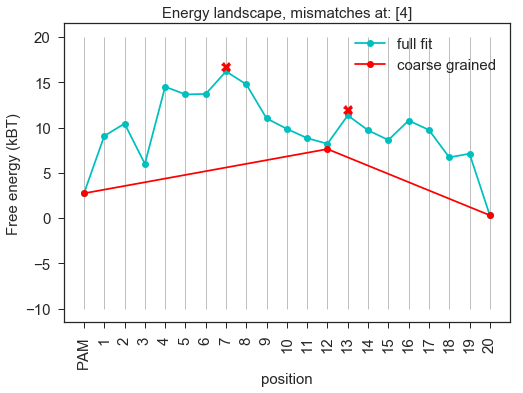

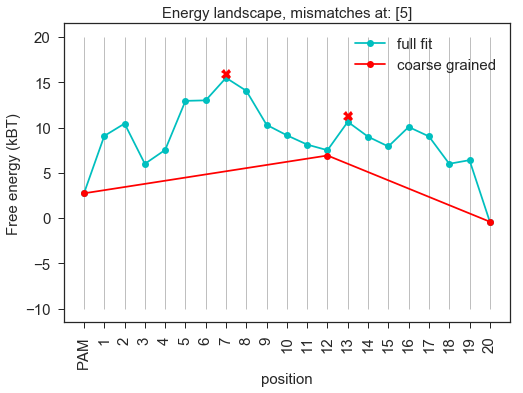

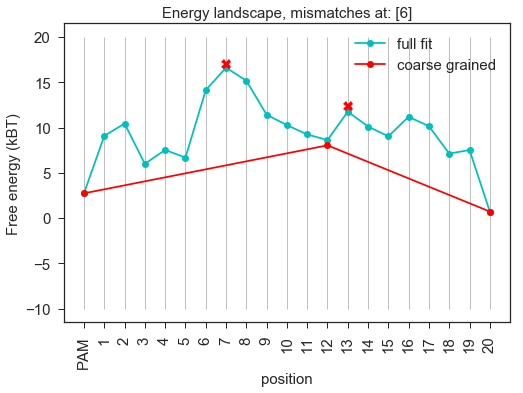

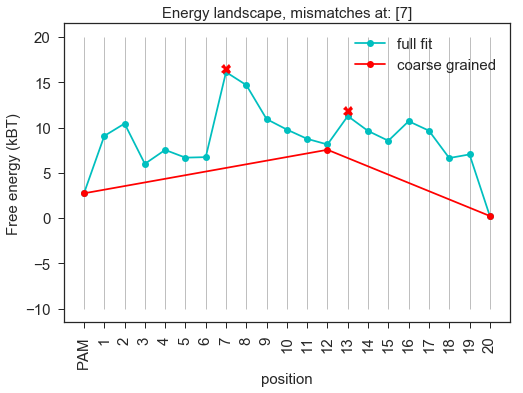

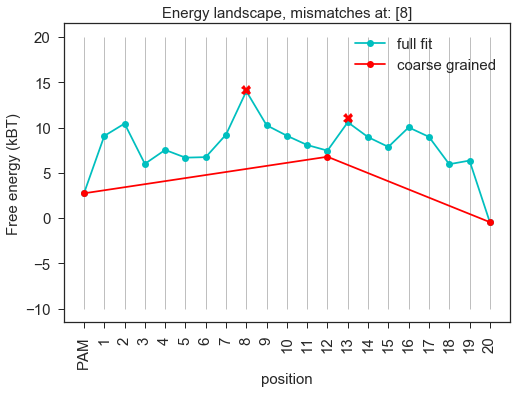

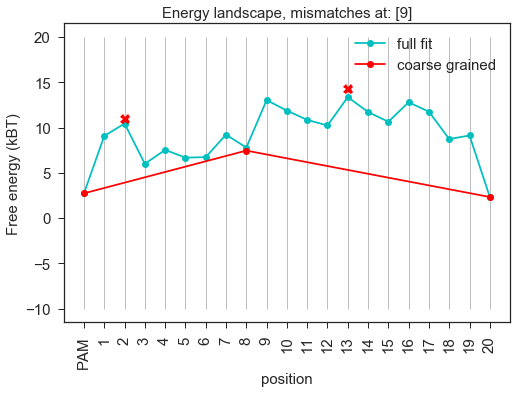

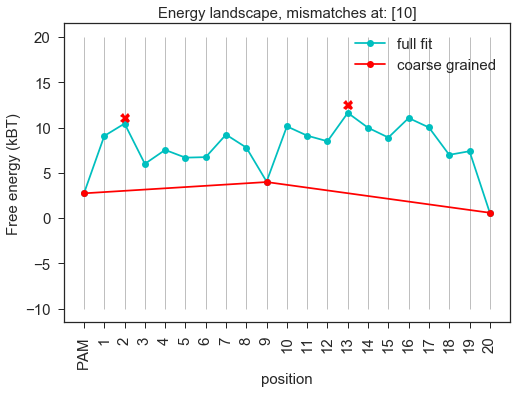

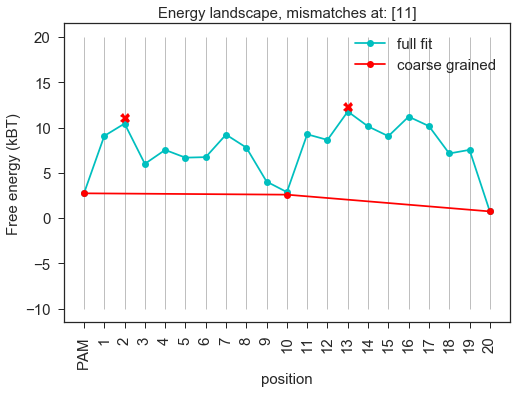

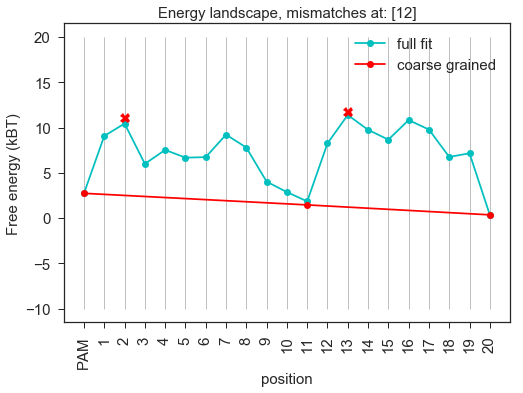

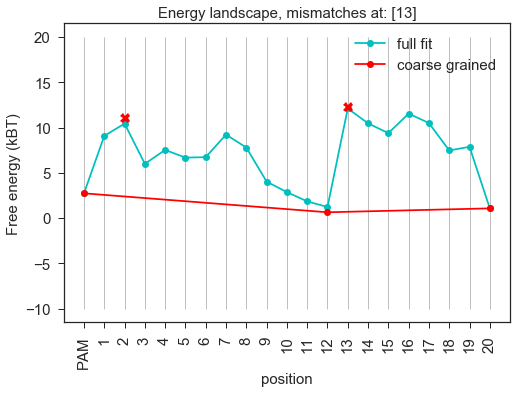

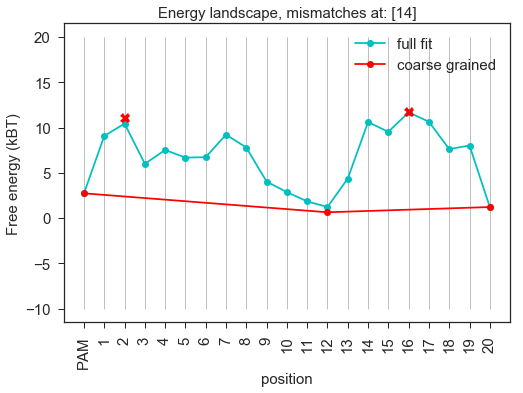

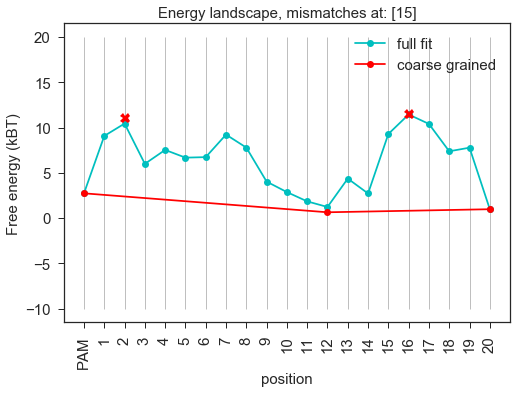

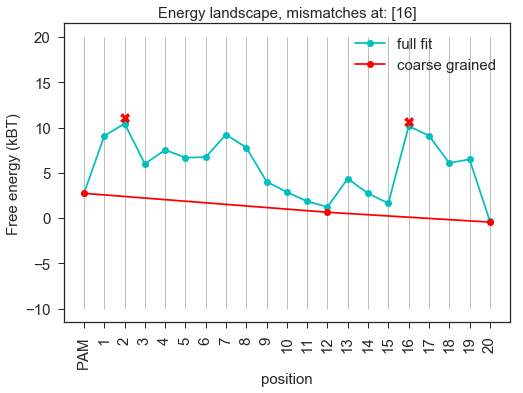

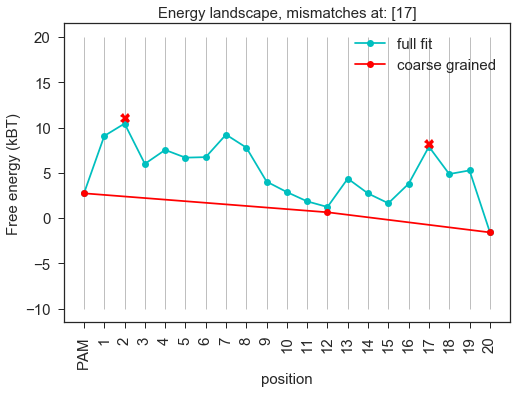

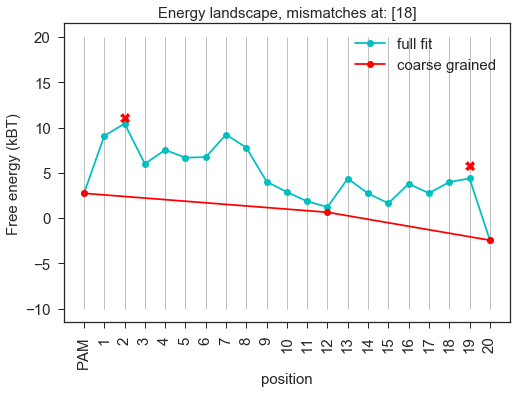

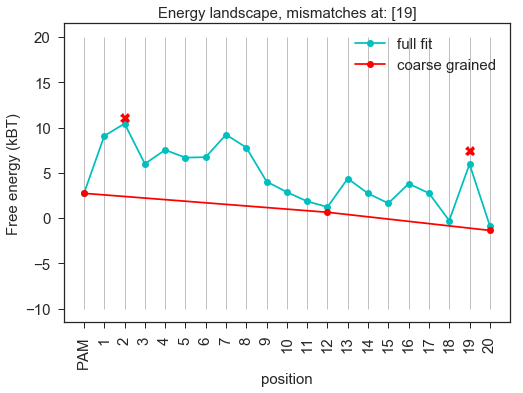

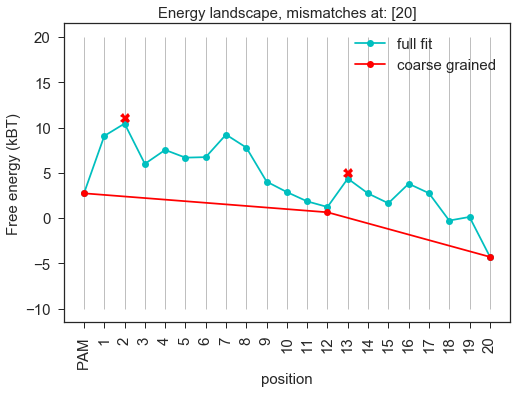

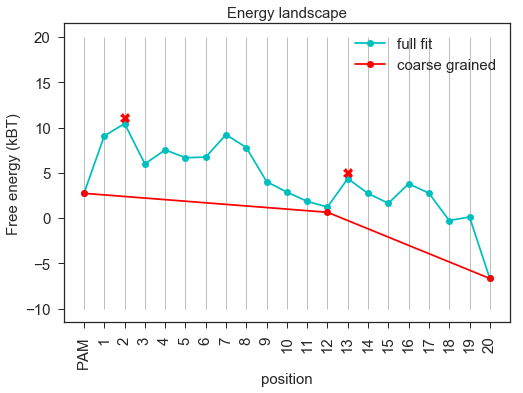

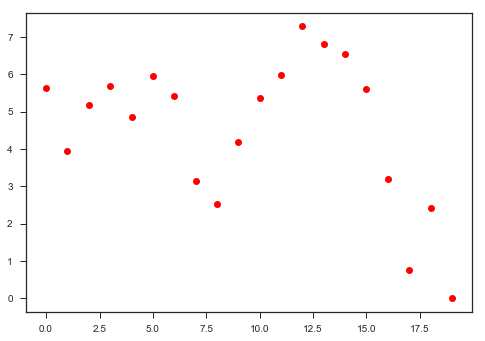

In [9]:
eicg = []
rangeI = [7,13]
rangeR = [15,21]
for i in range(1,22):
    ## Mismatch
    mismatch = [i]
    if i == 21:
        mismatch = []
    
    energies20 = energies.copy()
    for i in mismatch:
        energies20[i] -= energies20[i+20]
    
    rates_cg,energies_cg,Istate,Rstate,kclv_eff = cg.coarse_grain_4state_flexR(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)
    energies_cg[0] = -energies[0]
    barrier1 = -np.log(rates_cg[0]/rates[1])
    barrier2 = -np.log(rates_cg[1]/rates[1])
    landscape4 = -np.cumsum(energies_cg)
    landscape20 = -np.cumsum(np.append(-energies20[0],energies20[1:21]))

    plt.figure()
    plot5, = plt.plot(range(0,21),landscape20,'c-o',label='full fit')
    plot1, = plt.plot([0,Istate,Rstate],landscape4,'r-o',label='coarse grained')
    plt.plot([np.argmax(landscape20[0:Istate]),np.argmax(landscape20[Istate:])+Istate],[barrier1+landscape4[0],barrier2+landscape4[1]],'rX',markersize=10)
    plt.legend(handles=[plot5,plot1],fontsize=15)
    plt.xlabel('position',fontsize=15)
    plt.ylabel('Free energy (kBT)',fontsize=15)
    plt.title('Energy landscape',fontsize=15)
    if len(mismatch) > 0:
        plt.title('Energy landscape, mismatches at: ' + str(mismatch),fontsize=15)
    plt.vlines(range(0,21),-10,20,color='grey',linewidth=0.5);
    plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');
    plt.yticks(fontsize=15);
    
    if i < 9:
        eicg.append(barrier1)
    elif i==21:
        eicg.append(barrier1)
        eicg.append(barrier2)
    else:
        eicg.append(barrier2)

for i in range(0,8):
    eicg[i] = eicg[i] - eicg[-2]
for i in range(8,20):
    eicg[i] = eicg[i] - eicg[-1]
    
plt.figure()
plt.plot(eicg[:-2],'ro')


## Predicting using coarse grained rates

[16, 17]
0.0948009960579
2.39286365151
[16, 18]
0.217410079282
2.39286365151
[16, 19]
0.0476102323445
2.39286365151
[16, 20]
0.907250580315
2.39286365151
[17, 18]
0.557015542904
2.39286365151
[17, 19]
0.135960737122
2.39286365151
[18, 19]
0.236500411452
2.39286365151
[19, 20]
0.271981358143
2.39286365151


<function matplotlib.pyplot.tight_layout>

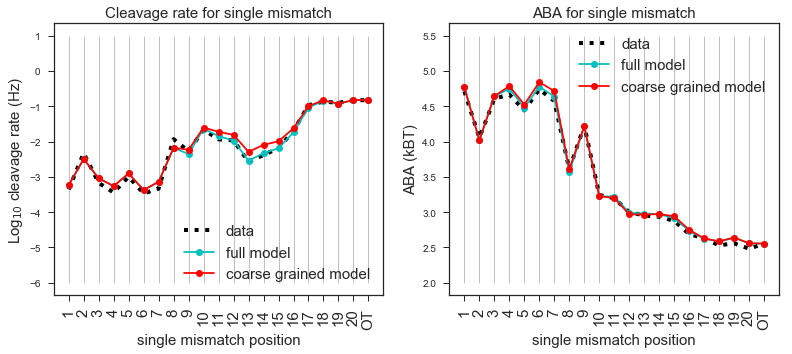

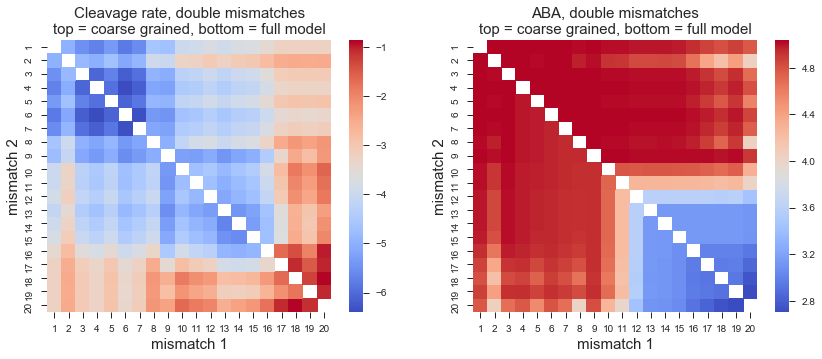

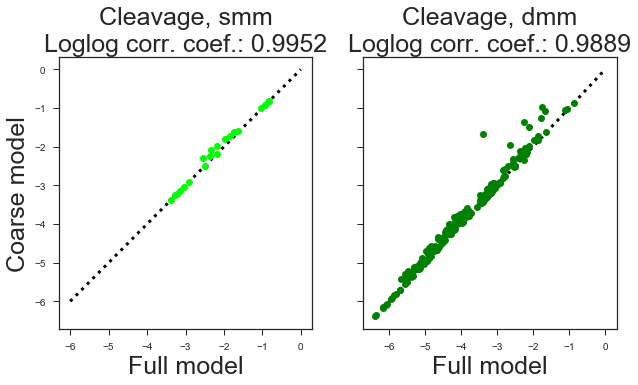

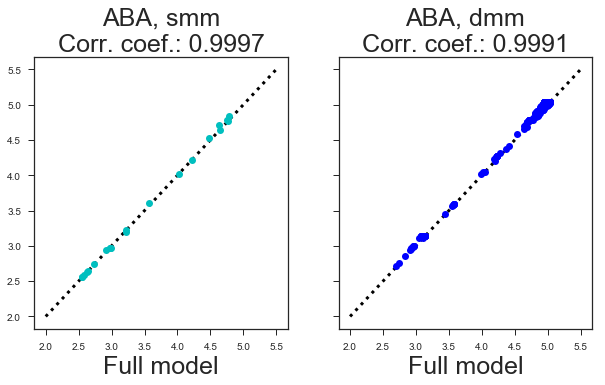

In [10]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)

conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair

kclv_full = []
kclv_coarse = []
aba_full = []
aba_coarse = []
for i in range(1,22):
    energies20 = energies.copy()

    ## Mismatch
    mismatch = [i]
    if i == 21:
        mismatch = []
    
    rates_cg,energies_cg,Istate,Rstate,kclv_eff = cg.coarse_grain_4state_flexR(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)
    kclv_coarse.append(np.log10(cg.calc_clv_rate_4state(rates_cg,1000,kclv_eff,energies_cg[0])))
    kclv_full.append(np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,mismatch)))
    aba_coarse.append(cg.calc_aba_4state(rates_cg,rates[0],-energies[0],conc,ref))
    aba_full.append(clv.calc_ABA(parameters_on,conc,ref,mismatch,model_ID_on))
    
f,ax = plt.subplots(1,2,sharey=False,figsize=[13,5])
ax[0].plot(range(1,22),kclv,color='k',linestyle=':',linewidth=4.)
ax[0].plot(range(1,22),kclv_full,color='c',marker='o')
ax[0].plot(range(1,22),kclv_coarse,color='r',marker='o')

ax[0].set_xticks(range(1,22));
ax[0].set_xticklabels(range(1,21)+['OT'],fontsize=15,rotation='vertical')
ax[0].legend(['data','full model','coarse grained model'],fontsize=15,loc = 'lower right')
ax[0].set_xlabel('single mismatch position', fontsize=15)
ax[0].set_ylabel('Log$_{10}$ cleavage rate (Hz)', fontsize=15)
ax[0].set_title('Cleavage rate for single mismatch', fontsize=15)
ax[0].vlines(range(1,22),-6,1,color='grey',linewidth=0.5);

ax[1].plot(range(1,22),aba,color='k',linestyle=':',linewidth=4.)
ax[1].plot(range(1,22),aba_full,color='c',marker='o')
ax[1].plot(range(1,22),aba_coarse,color='r',marker='o')

ax[1].vlines(range(1,22),2.,5.5,color='grey',linewidth=0.5)
ax[1].legend(['data','full model','coarse grained model'],fontsize=15)
ax[1].set_xlabel('single mismatch position', fontsize=15)
ax[1].set_ylabel('ABA (kBT)', fontsize=15)
ax[1].set_title('ABA for single mismatch', fontsize=15)
ax[1].set_xticks(range(1,22));
ax[1].set_xticklabels(range(1,21)+['OT'],fontsize=15,rotation='vertical')

doubleclvfull = []
doubleclvcoarse = []
doubleclv = np.zeros([20,20])

doubleabafull = []
doubleabacoarse = []
doubleaba = np.zeros([20,20])
plt.figure()
for j in range(1,20):
    for a in range(j+1,21):
        energies20 = energies.copy()

        ## Mismatch
        mismatch = [j,a]
        
        rates_cg,energies_cg,Istate,Rstate,kclv_eff = cg.coarse_grain_4state_flexR(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)
        if Rstate!=20:
            print mismatch
            print kclv_eff
            print rates_clv[-1]
        predtemp = np.log10(cg.calc_clv_rate_4state(rates_cg,1000,kclv_eff,energies_cg[0]))
        doubleclv[j-1][a-1] = predtemp
        doubleclvcoarse.append(predtemp)
        clvtemp = np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,[j,a]))
        doubleclv[a-1][j-1] = clvtemp
        doubleclvfull.append(clvtemp)

        predtemp = cg.calc_aba_4state(rates_cg,rates[0],-energies[0],conc,ref)
        doubleaba[j-1][a-1] = predtemp
        doubleabacoarse.append(predtemp)
        abatemp = clv.calc_ABA(parameters_on,conc,ref,mismatch,model_ID_on)
        doubleaba[a-1][j-1] = abatemp
        doubleabafull.append(abatemp)
        
doubleclv_df = pd.DataFrame(doubleclv, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    doubleclv_df[i].loc[i]=np.nan
doubleaba_df = pd.DataFrame(doubleaba, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    doubleaba_df[i].loc[i]=np.nan
    
f,ax = plt.subplots(1,2,sharey=False,figsize=[14,5])
sns.heatmap(doubleclv_df, cmap='coolwarm', cbar=True,ax=ax[0])
ax[0].set_xlabel('mismatch 1', fontsize=15)
ax[0].set_ylabel('mismatch 2', fontsize=15)
ax[0].set_title('Cleavage rate, double mismatches\ntop = coarse grained, bottom = full model',fontsize=15)
sns.heatmap(doubleaba_df, cmap='coolwarm', cbar=True,ax=ax[1])
ax[1].set_xlabel('mismatch 1', fontsize=15)
ax[1].set_ylabel('mismatch 2', fontsize=15)
ax[1].set_title('ABA, double mismatches\ntop = coarse grained, bottom = full model',fontsize=15)

f,ax = plt.subplots(1,2,sharey=True,figsize=[10,5])
ax[0].plot([-6.,0.],[-6.,0.],'k:',linewidth=3.)
ax[1].plot([-6.,0.],[-6.,0.],'k:',linewidth=3.)
ax[0].plot(kclv_full,kclv_coarse,color='lime',marker='o',linewidth=0.)
ax[1].plot(doubleclvfull,doubleclvcoarse,color='g',marker='o',linewidth=0.)
ax[0].set_title('Cleavage, smm\nLoglog corr. coef.: ' + str(np.round(np.corrcoef([kclv_full,kclv_coarse])[0][1],4)), fontsize=25)
ax[1].set_title('Cleavage, dmm\nLoglog corr. coef.: '+ str(np.round(np.corrcoef([doubleclvfull,doubleclvcoarse])[0][1],4)), fontsize=25)
ax[0].set_xlabel('Full model',fontsize=25)
ax[1].set_xlabel('Full model',fontsize=25)
ax[0].set_ylabel('Coarse model',fontsize=25)

f,ax = plt.subplots(1,2,sharey=True,figsize=[10,5])
ax[0].plot([2.,5.5],[2.,5.5],'k:',linewidth=3.)
ax[1].plot([2.,5.5],[2.,5.5],'k:',linewidth=3.)
ax[0].plot(aba_full,aba_coarse,color='c',marker='o',linewidth=0.)
ax[1].plot(doubleabafull,doubleabacoarse,color='b',marker='o',linewidth=0.)
ax[0].set_title('ABA, smm\nCorr. coef.: ' + str(np.round(np.corrcoef([aba_full,aba_coarse])[0][1],4)), fontsize=25)
ax[1].set_title('ABA, dmm\nCorr. coef.: '+ str(np.round(np.corrcoef([doubleabafull,doubleabacoarse])[0][1],4)), fontsize=25)
ax[0].set_xlabel('Full model',fontsize=25)
ax[1].set_xlabel('Full model',fontsize=25)
#ax[0].set_ylabel('Coarse model',fontsize=20)
        
plt.tight_layout

## CoarseClv

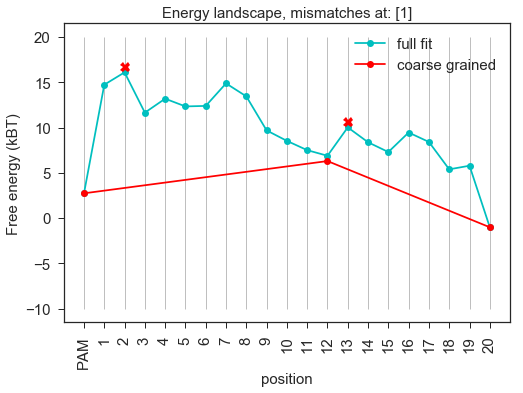

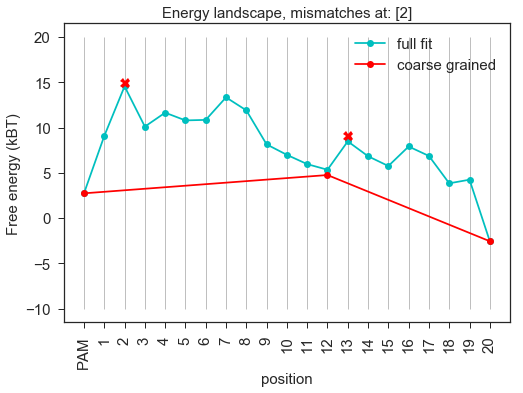

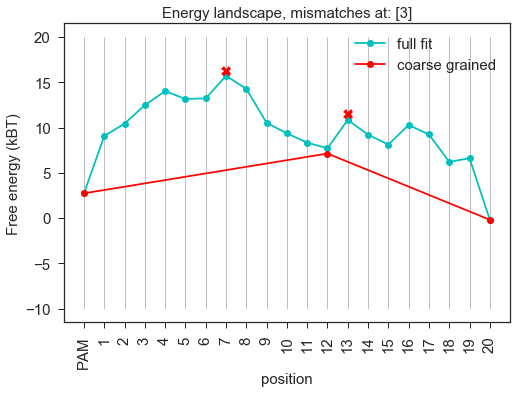

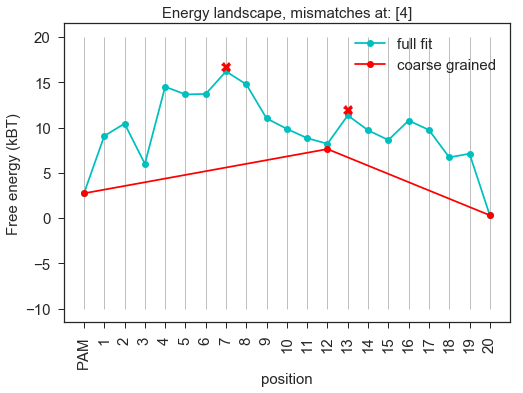

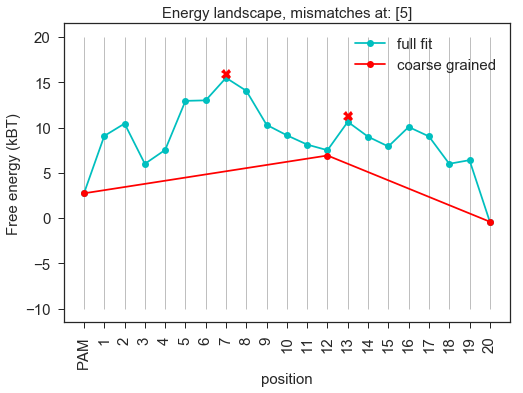

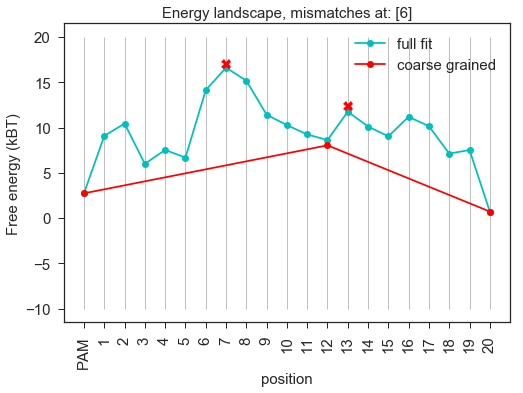

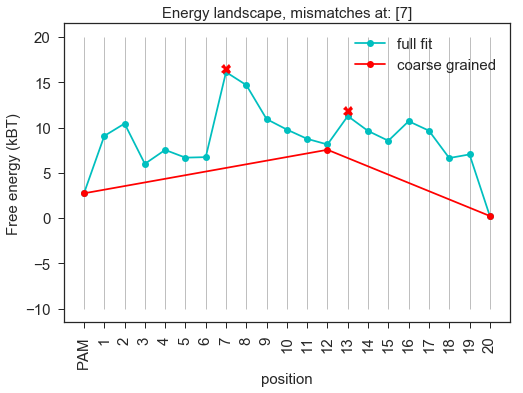

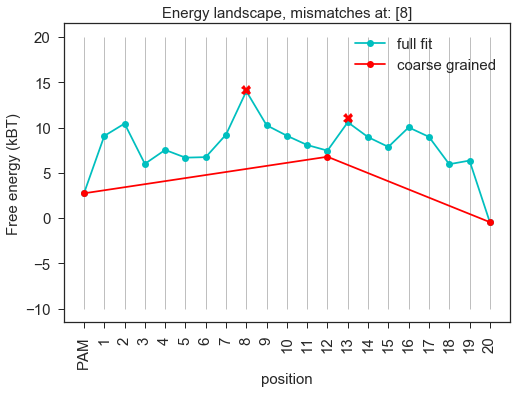

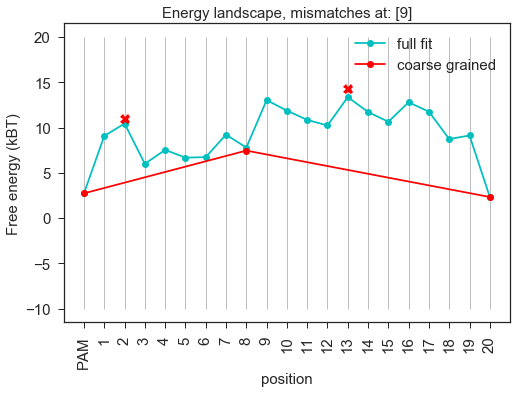

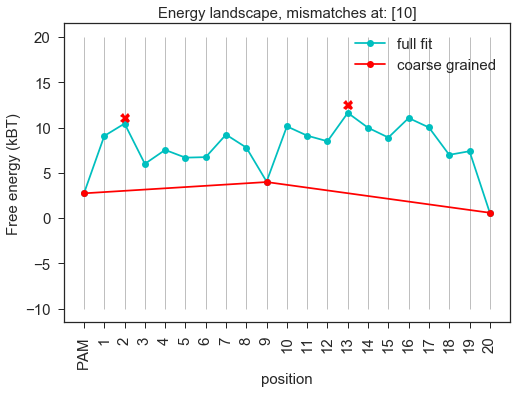

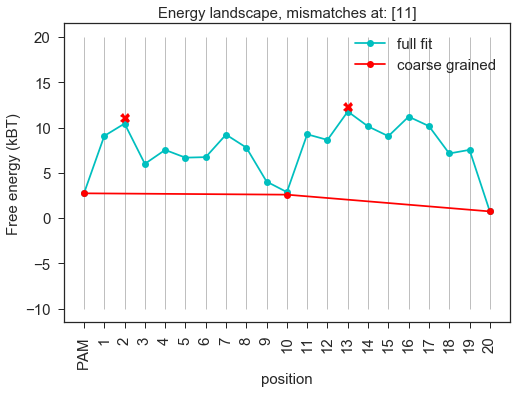

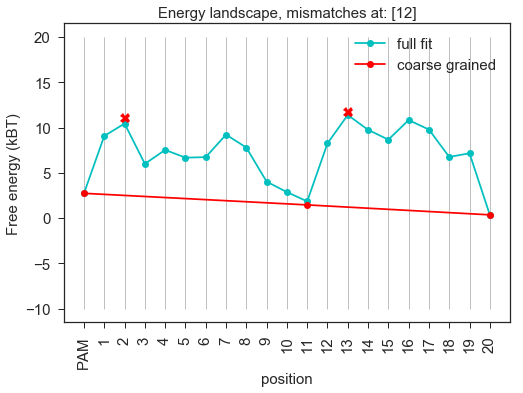

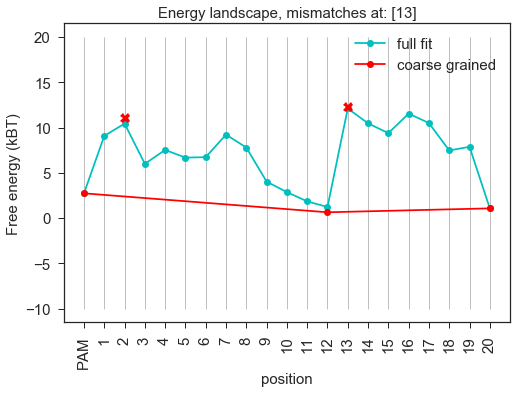

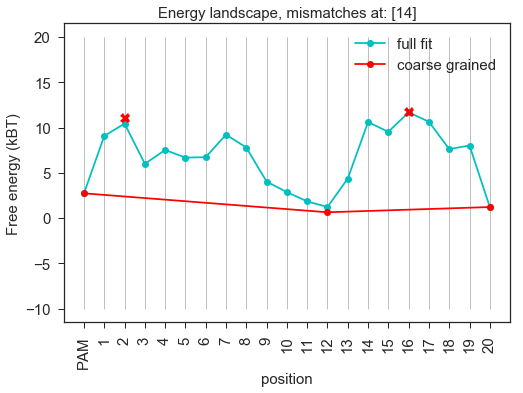

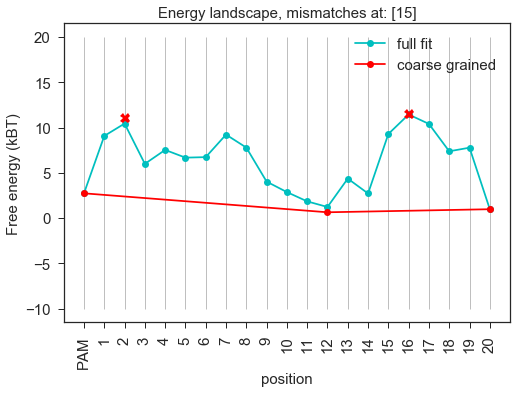

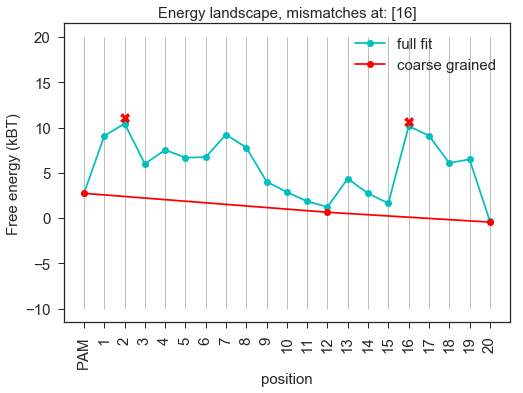

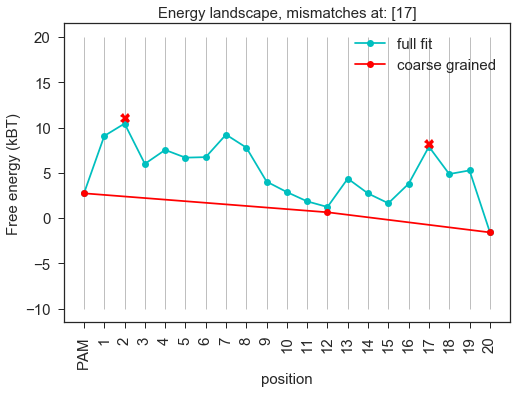

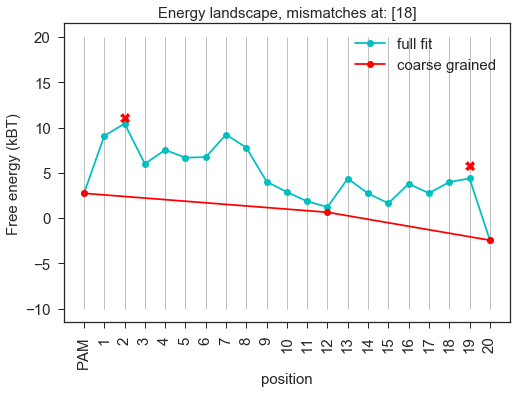

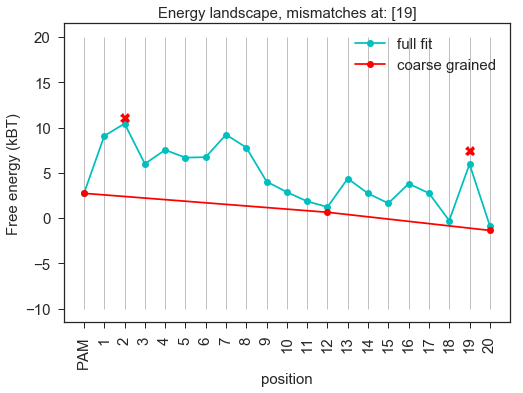

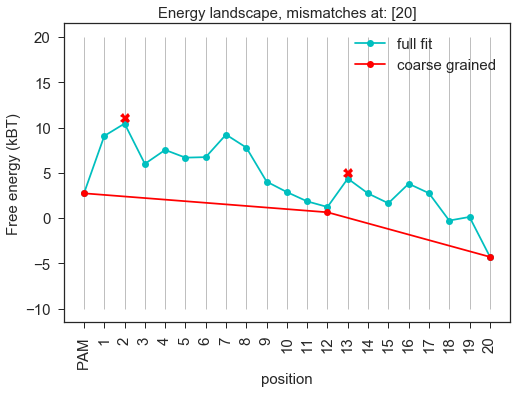

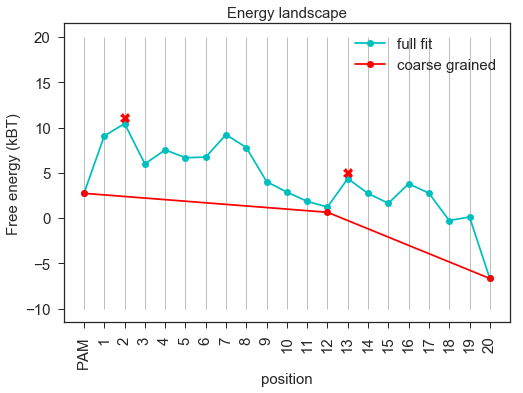

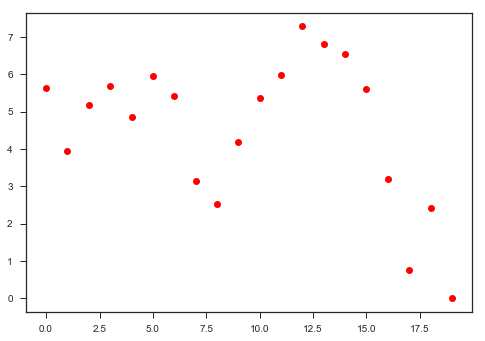

In [11]:
eicg = []
rangeI = [7,13]
rangeR = [15,21]
for i in range(1,22):
    ## Mismatch
    mismatch = [i]
    if i == 21:
        mismatch = []
    
    energies20 = energies.copy()
    for i in mismatch:
        energies20[i] -= energies20[i+20]
    
    rates_cg,energies_cg,Istate,Rstate,kclv_eff = cg.coarse_grain_4state_coarseClv(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)
    energies_cg[0] = -energies[0]
    barrier1 = -np.log(rates_cg[0]/rates[1])
    barrier2 = -np.log(rates_cg[1]/rates[1])
    landscape4 = -np.cumsum(energies_cg)
    landscape20 = -np.cumsum(np.append(-energies20[0],energies20[1:21]))

    plt.figure()
    plot5, = plt.plot(range(0,21),landscape20,'c-o',label='full fit')
    plot1, = plt.plot([0,Istate,Rstate],landscape4,'r-o',label='coarse grained')
    plt.plot([np.argmax(landscape20[0:Istate]),np.argmax(landscape20[Istate:Rstate])+Istate],[barrier1+landscape4[0],barrier2+landscape4[1]],'rX',markersize=10)
    plt.legend(handles=[plot5,plot1],fontsize=15)
    plt.xlabel('position',fontsize=15)
    plt.ylabel('Free energy (kBT)',fontsize=15)
    plt.title('Energy landscape',fontsize=15)
    if len(mismatch) > 0:
        plt.title('Energy landscape, mismatches at: ' + str(mismatch),fontsize=15)
    plt.vlines(range(0,21),-10,20,color='grey',linewidth=0.5);
    plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');
    plt.yticks(fontsize=15);
    
    if i < 9:
        eicg.append(barrier1)
    elif i==21:
        eicg.append(barrier1)
        eicg.append(barrier2)
    else:
        eicg.append(barrier2)

for i in range(0,8):
    eicg[i] = eicg[i] - eicg[-2]
for i in range(8,20):
    eicg[i] = eicg[i] - eicg[-1]
    
plt.figure()
plt.plot(eicg[:-2],'ro')


[16, 17] 15
0.0018618789865904291
2.392863651511265
[16, 18] 15
0.026150088015711778
2.392863651511265
[16, 19] 15
0.010011754562073977
2.392863651511265
[16, 20] 15
0.08398712619914597
2.392863651511265
[17, 18] 15
0.09668831485179992
2.392863651511265
[17, 19] 15
0.03192489219961123
2.392863651511265
[18, 19] 15
0.059121153677946306
2.392863651511265
[19, 20] 18
0.25654982510227015
2.392863651511265


<function matplotlib.pyplot.tight_layout>

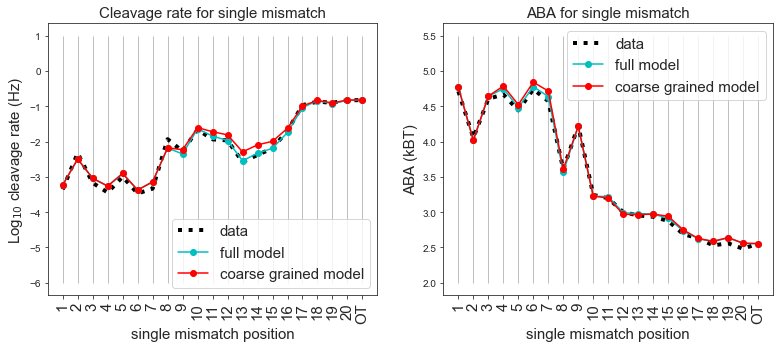

<Figure size 432x288 with 0 Axes>

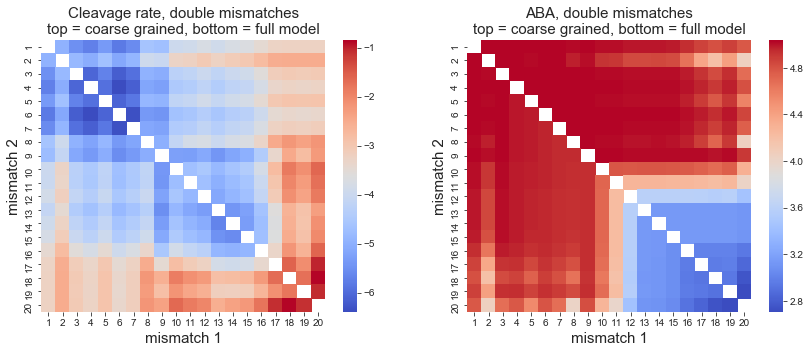

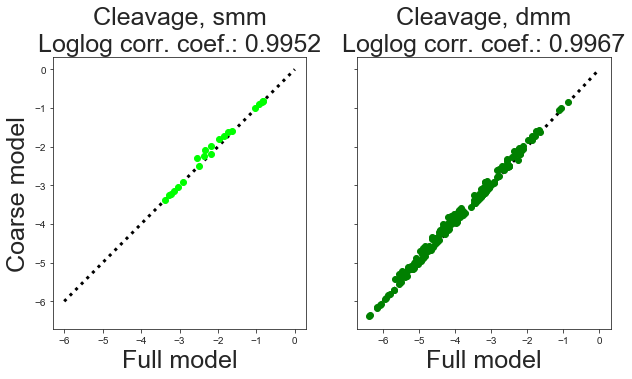

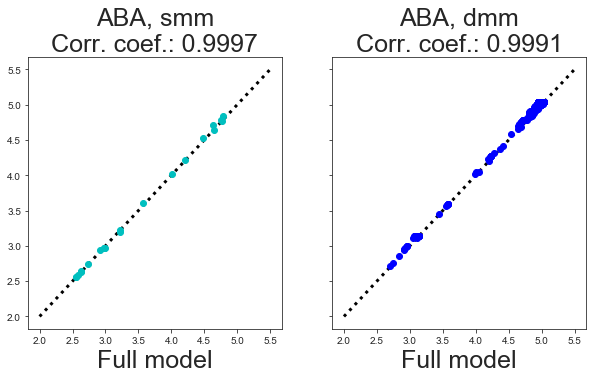

In [15]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt'
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
_,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)

conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
ref = 10. # in nanomolair

kclv_full = []
kclv_coarse = []
aba_full = []
aba_coarse = []
for i in range(1,22):
    energies20 = energies.copy()

    ## Mismatch
    mismatch = [i]
    if i == 21:
        mismatch = []
    
    rates_cg,energies_cg,Istate,Rstate,kclv_eff = cg.coarse_grain_4state_coarseClv(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)
    kclv_coarse.append(np.log10(cg.calc_clv_rate_4state(rates_cg,1000,kclv_eff,energies_cg[0])))
    kclv_full.append(np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,mismatch)))
    aba_coarse.append(cg.calc_aba_4state(rates_cg,rates[0],-energies[0],conc,ref))
    aba_full.append(clv.calc_ABA(parameters_on,conc,ref,mismatch,model_ID_on))
    
f,ax = plt.subplots(1,2,sharey=False,figsize=[13,5])
ax[0].plot(range(1,22),kclv,color='k',linestyle=':',linewidth=4.)
ax[0].plot(range(1,22),kclv_full,color='c',marker='o')
ax[0].plot(range(1,22),kclv_coarse,color='r',marker='o')

ax[0].set_xticks(range(1,22));
ax[0].set_xticklabels(range(1,21)+['OT'],fontsize=15,rotation='vertical')
ax[0].legend(['data','full model','coarse grained model'],fontsize=15,loc = 'lower right')
ax[0].set_xlabel('single mismatch position', fontsize=15)
ax[0].set_ylabel('Log$_{10}$ cleavage rate (Hz)', fontsize=15)
ax[0].set_title('Cleavage rate for single mismatch', fontsize=15)
ax[0].vlines(range(1,22),-6,1,color='grey',linewidth=0.5);

ax[1].plot(range(1,22),aba,color='k',linestyle=':',linewidth=4.)
ax[1].plot(range(1,22),aba_full,color='c',marker='o')
ax[1].plot(range(1,22),aba_coarse,color='r',marker='o')

ax[1].vlines(range(1,22),2.,5.5,color='grey',linewidth=0.5)
ax[1].legend(['data','full model','coarse grained model'],fontsize=15)
ax[1].set_xlabel('single mismatch position', fontsize=15)
ax[1].set_ylabel('ABA (kBT)', fontsize=15)
ax[1].set_title('ABA for single mismatch', fontsize=15)
ax[1].set_xticks(range(1,22));
ax[1].set_xticklabels(range(1,21)+['OT'],fontsize=15,rotation='vertical')

doubleclvfull = []
doubleclvcoarse = []
doubleclv = np.zeros([20,20])

doubleabafull = []
doubleabacoarse = []
doubleaba = np.zeros([20,20])
plt.figure()
for j in range(1,20):
    for a in range(j+1,21):
        energies20 = energies.copy()

        ## Mismatch
        mismatch = [j,a]
        
        rates_cg,energies_cg,Istate,Rstate,kclv_eff = cg.coarse_grain_4state_coarseClv(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)
        if Rstate!=20:
            print mismatch, Rstate
            print kclv_eff
            print rates_clv[-1]
        predtemp = np.log10(cg.calc_clv_rate_4state(rates_cg,1000,kclv_eff,energies_cg[0]))
        doubleclv[j-1][a-1] = predtemp
        doubleclvcoarse.append(predtemp)
        clvtemp = np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,[j,a]))
        doubleclv[a-1][j-1] = clvtemp
        doubleclvfull.append(clvtemp)

        predtemp = cg.calc_aba_4state(rates_cg,rates[0],-energies[0],conc,ref)
        doubleaba[j-1][a-1] = predtemp
        doubleabacoarse.append(predtemp)
        abatemp = clv.calc_ABA(parameters_on,conc,ref,mismatch,model_ID_on)
        doubleaba[a-1][j-1] = abatemp
        doubleabafull.append(abatemp)
        
doubleclv_df = pd.DataFrame(doubleclv, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    doubleclv_df[i].loc[i]=np.nan
doubleaba_df = pd.DataFrame(doubleaba, index=range(1, 21), columns=range(1, 21))
for i in range(1,21):
    doubleaba_df[i].loc[i]=np.nan
    
f,ax = plt.subplots(1,2,sharey=False,figsize=[14,5])
sns.heatmap(doubleclv_df, cmap='coolwarm', cbar=True,ax=ax[0])
ax[0].set_xlabel('mismatch 1', fontsize=15)
ax[0].set_ylabel('mismatch 2', fontsize=15)
ax[0].set_title('Cleavage rate, double mismatches\ntop = coarse grained, bottom = full model',fontsize=15)
sns.heatmap(doubleaba_df, cmap='coolwarm', cbar=True,ax=ax[1])
ax[1].set_xlabel('mismatch 1', fontsize=15)
ax[1].set_ylabel('mismatch 2', fontsize=15)
ax[1].set_title('ABA, double mismatches\ntop = coarse grained, bottom = full model',fontsize=15)

f,ax = plt.subplots(1,2,sharey=True,figsize=[10,5])
ax[0].plot([-6.,0.],[-6.,0.],'k:',linewidth=3.)
ax[1].plot([-6.,0.],[-6.,0.],'k:',linewidth=3.)
ax[0].plot(kclv_full,kclv_coarse,color='lime',marker='o',linewidth=0.)
ax[1].plot(doubleclvfull,doubleclvcoarse,color='g',marker='o',linewidth=0.)
ax[0].set_title('Cleavage, smm\nLoglog corr. coef.: ' + str(np.round(np.corrcoef([kclv_full,kclv_coarse])[0][1],4)), fontsize=25)
ax[1].set_title('Cleavage, dmm\nLoglog corr. coef.: '+ str(np.round(np.corrcoef([doubleclvfull,doubleclvcoarse])[0][1],4)), fontsize=25)
ax[0].set_xlabel('Full model',fontsize=25)
ax[1].set_xlabel('Full model',fontsize=25)
ax[0].set_ylabel('Coarse model',fontsize=25)

f,ax = plt.subplots(1,2,sharey=True,figsize=[10,5])
ax[0].plot([2.,5.5],[2.,5.5],'k:',linewidth=3.)
ax[1].plot([2.,5.5],[2.,5.5],'k:',linewidth=3.)
ax[0].plot(aba_full,aba_coarse,color='c',marker='o',linewidth=0.)
ax[1].plot(doubleabafull,doubleabacoarse,color='b',marker='o',linewidth=0.)
ax[0].set_title('ABA, smm\nCorr. coef.: ' + str(np.round(np.corrcoef([aba_full,aba_coarse])[0][1],4)), fontsize=25)
ax[1].set_title('ABA, dmm\nCorr. coef.: '+ str(np.round(np.corrcoef([doubleabafull,doubleabacoarse])[0][1],4)), fontsize=25)
ax[0].set_xlabel('Full model',fontsize=25)
ax[1].set_xlabel('Full model',fontsize=25)
#ax[0].set_ylabel('Coarse model',fontsize=20)
        
plt.tight_layout

37
2


[0.5, 4.5, -4.1, 1.5]

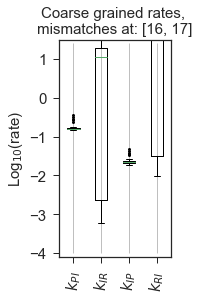

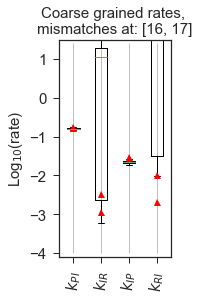

In [12]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'
rates_list = []
cleave_list = []

mismatch = [16,17]
for i in range(1,51):
    filename = 'fit_18_7_2019_sim_' + str(i) + '.txt'
    path = '../fits_Stijn/18_7_2019/'
    data = pd.read_table(path+filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    
    if np.min(chi)<290.:

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
        energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
        
        rates_cg,energies_cg,Istate,Rstate,kclv_eff = cg.coarse_grain_4state_coarseClv(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)

        rates_list.append(np.log10(np.array(rates_cg)))
        cleave_list.append(np.log10(rates_clv[-1]))
print len(rates_list)

rates_list2 = []
cleave_list2 = []
for i in range(1,6):
    filename = 'fit_8_8_2019_sim_' + str(i) + '.txt'
    path = '../fits_Stijn/8_8_2019/'
    data = pd.read_table(path+filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    
    if np.min(chi)<400.:

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np,model_ID)
        energies,rates = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)
        
        rates_cg,energies_cg,Istate,Rstate,kclv_eff = cg.coarse_grain_4state_coarseClv(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)

        rates_list2.append(np.log10(np.array(rates_cg)))
        cleave_list2.append(np.log10(rates_clv[-1]))
print len(rates_list2)

rates_listT = np.transpose(np.array(rates_list))
rates_list = np.array(rates_list)
ro = dict(markerfacecolor='k', marker='o',markeredgecolor='k',markersize=3.)


plt.figure(figsize = [2,4])
plt.boxplot(rates_list,flierprops=ro)
plt.title('Coarse grained rates',fontsize=15)
if len(mismatch) > 0:
    plt.title('Coarse grained rates, \nmismatches at: ' + str(mismatch),fontsize=15)
plt.vlines(range(1,5),-4.,1.4,color='grey',linewidth=0.5);
plt.xticks(range(1,5),['$k_{PI}$','$k_{IR}$','$k_{IP}$','$k_{RI}$'],fontsize=15,rotation='vertical');
plt.ylabel('Log$_{10}$(rate)',fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.5,4.5,-4.1,1.5])

plt.figure(figsize = [2,4])
plt.boxplot(rates_list,showfliers=False)
plt.title('Coarse grained rates',fontsize=15)
for i in range(len(rates_list2)):
    plot2, = plt.plot(range(1,5),rates_list2[i],'r^',markersize=7.,linewidth=0,label='unconstrained $k_f$')
if len(mismatch) > 0:
    plt.title('Coarse grained rates, \nmismatches at: ' + str(mismatch),fontsize=15)
plt.vlines(range(1,5),-4.,1.4,color='grey',linewidth=0.5);
plt.xticks(range(1,5),['$k_{PI}$','$k_{IR}$','$k_{IP}$','$k_{RI}$'],fontsize=15,rotation='vertical');
plt.ylabel('Log$_{10}$(rate)',fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0.5,4.5,-4.1,1.5])

## Comparing the three methods

13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13


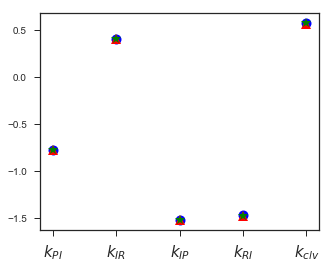

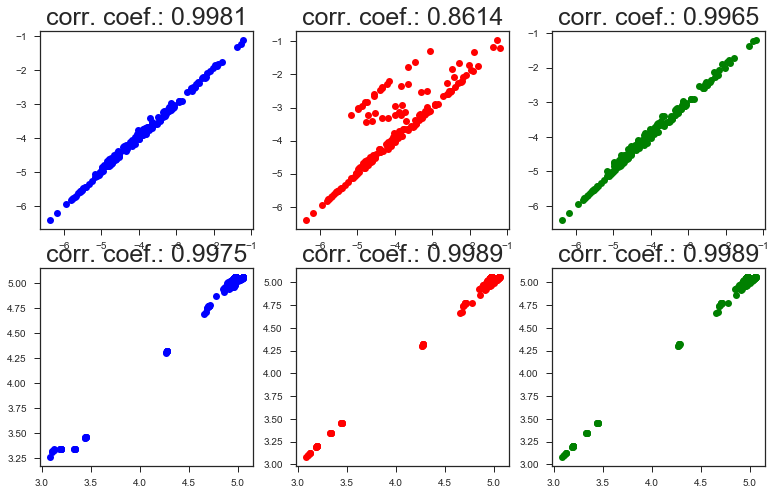

In [13]:
mismatch = [20]

rangeI = [7,13]
rangeR = [13,21]

full = []
coarse = []
flexR = []
coarseClv = []

fullaba = []
coarseaba = []
flexRaba = []
coarseClvaba = []

rates_cg1,energies_cg,Istate = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,rangeI)
rates_cg2,energies_cg,Istate,Rstate,kclv_eff2 = cg.coarse_grain_4state_flexR(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)
rates_cg3,energies_cg,Istate,Rstate,kclv_eff3 = cg.coarse_grain_4state_coarseClv(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)

plt.figure(figsize=[5,4])
plt.plot(range(1,6),np.log10(np.append(rates_cg1,rates_clv[-1])),'bo',markersize=10.)
plt.plot(range(1,6),np.log10(np.append(rates_cg2,kclv_eff2)),'r^',markersize=10.)
plt.plot(range(1,6),np.log10(np.append(rates_cg3,kclv_eff3)),'g*',markersize=10.)
plt.xticks(range(1,6),['$k_{PI}$','$k_{IR}$','$k_{IP}$','$k_{RI}$','$k_{clv}$'],fontsize=15);

for i in range(1,19):
    for j in range(i+1,20):
        mismatch = [i,j,20]
        
        rates_cg1,energies_cg1,_ = cg.coarse_grain_4state(parameters_clv,model_ID_clv,mismatch,rangeI)
        rates_cg2,energies_cg2,_,_,kclv_eff2 = cg.coarse_grain_4state_flexR(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)
        rates_cg3,energies_cg3,_,Rstate,kclv_eff3 = cg.coarse_grain_4state_coarseClv(parameters_clv,model_ID_clv,mismatch,rangeI,rangeR)
        
        predtemp1 = np.log10(cg.calc_clv_rate_4state(rates_cg1,1000,rates_clv[-1],energies_cg1[0]))
        predtemp2 = np.log10(cg.calc_clv_rate_4state(rates_cg2,1000,kclv_eff2,energies_cg2[0]))
        predtemp3 = np.log10(cg.calc_clv_rate_4state(rates_cg3,1000,kclv_eff3,energies_cg3[0]))
        coarse.append(predtemp1)
        flexR.append(predtemp2)
        coarseClv.append(predtemp3)
        clvtemp = np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,mismatch))
        full.append(clvtemp)
        
        if Rstate != 20:
            print Rstate

        predtemp1 = cg.calc_aba_4state(rates_cg1,rates[0],-energies[0],conc,ref)
        predtemp2 = cg.calc_aba_4state(rates_cg2,rates[0],-energies[0],conc,ref)
        predtemp3 = cg.calc_aba_4state(rates_cg3,rates[0],-energies[0],conc,ref)
        coarseaba.append(predtemp1)
        flexRaba.append(predtemp2)
        coarseClvaba.append(predtemp3)
        abatemp = clv.calc_ABA(parameters_on,conc,ref,mismatch,model_ID_on)
        fullaba.append(abatemp)
        
f,ax = plt.subplots(2,3,sharey=False,figsize=[13,8])
ax[0][0].plot(full,coarse,'bo',linewidth=0.)
ax[0][0].set_title('corr. coef.: ' + str(np.round(np.corrcoef([full,coarse])[0][1],4)), fontsize=25)
ax[1][0].plot(fullaba,coarseaba,'bo',linewidth=0.)
ax[1][0].set_title('corr. coef.: ' + str(np.round(np.corrcoef([fullaba,coarseaba])[0][1],4)), fontsize=25)
ax[0][1].plot(full,flexR,'ro',linewidth=0.)
ax[0][1].set_title('corr. coef.: ' + str(np.round(np.corrcoef([full,flexR])[0][1],4)), fontsize=25)
ax[1][1].plot(fullaba,flexRaba,'ro',linewidth=0.)
ax[1][1].set_title('corr. coef.: ' + str(np.round(np.corrcoef([fullaba,flexRaba])[0][1],4)), fontsize=25)
ax[0][2].plot(full,coarseClv,'go',linewidth=0.)
ax[0][2].set_title('corr. coef.: ' + str(np.round(np.corrcoef([full,coarseClv])[0][1],4)), fontsize=25)
ax[1][2].plot(fullaba,coarseClvaba,'go',linewidth=0.)
ax[1][2].set_title('corr. coef.: ' + str(np.round(np.corrcoef([fullaba,coarseClvaba])[0][1],4)), fontsize=25)